# **Connect to google drive**

In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# **Importing necessary modules**

In [2]:
!pip install torchinfo

In [3]:
from pathlib import Path
import random
import IPython.display as display
import torch
import torch.nn as nn
import torchaudio
from torchinfo import summary
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from sklearn.metrics import classification_report
from torch.utils.data import Dataset,DataLoader

In [4]:
data_path = Path('/content/drive/MyDrive/Animals')
data_path

PosixPath('/content/drive/MyDrive/Animals')

In [5]:
audio_list = list(data_path.glob('*/*.wav'))
len(audio_list)

610

In [6]:
sample = random.choice(audio_list)
display.Audio(sample)

sample rate:16000


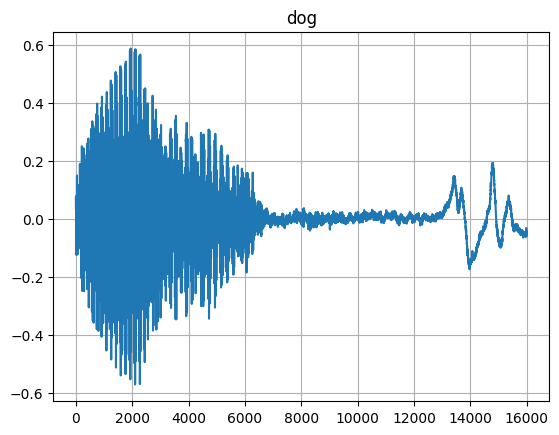

In [7]:
sample = random.choice(audio_list)
waveform,sample_rate = torchaudio.load(sample)
print(f'sample rate:{sample_rate}')
plt.plot(waveform.t().numpy())
plt.title(sample.parent.stem)
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Text(0.5, 1.0, 'cat:torch.Size([1, 128, 81])')

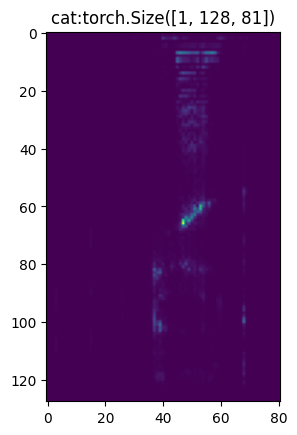

In [8]:

sample = random.choice(audio_list)
waveform,_ = torchaudio.load(sample)
mel = T.MelSpectrogram(16000)
transformed = mel(waveform)
plt.imshow(transformed.permute(1,2,0).cpu())
plt.title(f'{sample.parent.stem}:{transformed.shape}')

In [9]:
L = []
for i in audio_list:
     waveform,_ = torchaudio.load(i)
     L.append(len(waveform.squeeze(0)))
print(max(L))

KeyboardInterrupt: ignored

In [ ]:
print(L)

In [10]:
labels = list(set(list(i.parent.stem for i in audio_list)))
labels
label_encoder = {v:k for k,v in enumerate(labels)}
label_encoder

{'dog': 0, 'cat': 1, 'bird': 2}

In [12]:
class AudioData(Dataset):
    def __init__(self, input, target=label_encoder):
        super().__init__()
        self.input = input
        self.target = target
        self.mel = T.MelSpectrogram(16000)
    def __len__(self):
        return len(self.input)

    def preprocess(self, x):
        y = len(x.squeeze(0))
        z = x.squeeze(0)

        if y < 16000:
            pad_size = 16000 - y
            z = F.pad(z, (0, pad_size))

        return z.unsqueeze(0)

    def __getitem__(self, idx):
        x = self.input[idx]
        waveform, _ = torchaudio.load(x)
        preprocessed = self.preprocess(waveform)
        f = self.mel(preprocessed)
        y = x.parent.stem
        return f, self.target[y]

In [13]:
random.shuffle(audio_list)
train = audio_list[:480]
test = audio_list[480:]

In [14]:
train_data = AudioData(train)
test_data = AudioData(test)

In [15]:
sample,label = train_data[0]
sample,label,sample.shape

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2263e-03, 7.3626e-04, 1.2894e-04,  ..., 1.3744e-05,
           9.3410e-04, 1.6084e-03],
          [6.6030e-03, 3.9642e-03, 6.9427e-04,  ..., 7.4001e-05,
           5.0295e-03, 8.6600e-03],
          ...,
          [4.8097e-07, 2.4176e-07, 1.0144e-07,  ..., 1.0184e-07,
           1.1780e-07, 1.7670e-06],
          [7.0036e-07, 3.4268e-08, 3.2725e-08,  ..., 7.5486e-08,
           4.6118e-08, 2.2341e-06],
          [5.9248e-07, 7.2903e-08, 2.5467e-08,  ..., 4.2368e-08,
           3.4011e-08, 2.5946e-06]]]),
 2,
 torch.Size([1, 128, 81]))

In [16]:
bs = 1
train_loader = DataLoader(
       train_data,
       batch_size=bs,
       shuffle=True
)
test_loader = DataLoader(
       test_data,
       batch_size=bs,
       shuffle=False
)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
class CNN(nn.Module):
       def __init__(self,input=1,output=len(labels)):
                super().__init__()
                self.conv1 = nn.Sequential(
                     nn.Conv2d(in_channels=input,out_channels=8,kernel_size=2,stride=1),
                     nn.ReLU(),
                     nn.Conv2d(8,8,2,1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,1)

                )
                self.fc = nn.Sequential(
                     nn.Linear(78000,10),
                     nn.Dropout(0.3,True),
                     nn.ReLU(),
                     nn.Linear(10,output)
                )
       def forward(self,x):
           x = self.conv1(x)
           x = torch.flatten(x,start_dim=1)
           x = self.fc(x)
           return x

In [19]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=78000, out_features=10, bias=True)
    (1): Dropout(p=0.3, inplace=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=3, bias=True)
  )
)


In [20]:
summary(cnn,[1,1,128,81])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 3]                    --
├─Sequential: 1-1                        [1, 8, 125, 78]           --
│    └─Conv2d: 2-1                       [1, 8, 127, 80]           40
│    └─ReLU: 2-2                         [1, 8, 127, 80]           --
│    └─Conv2d: 2-3                       [1, 8, 126, 79]           264
│    └─ReLU: 2-4                         [1, 8, 126, 79]           --
│    └─MaxPool2d: 2-5                    [1, 8, 125, 78]           --
├─Sequential: 1-2                        [1, 3]                    --
│    └─Linear: 2-6                       [1, 10]                   780,010
│    └─Dropout: 2-7                      [1, 10]                   --
│    └─ReLU: 2-8                         [1, 10]                   --
│    └─Linear: 2-9                       [1, 3]                    33
Total params: 780,347
Trainable params: 780,347
Non-trainable params: 0
Total m

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    cnn.parameters(),
    lr=0.00001,
    weight_decay=0.0001
)

In [22]:
def train_step(
        model,
        data=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    ):
    model.train()
    train_loss = 0
    for X,y in data:
        X,y = X.to(device),y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(data)
    return train_loss

In [23]:
def test_step(
        model,
        data=test_loader,
        loss_fn=loss_fn,
        device=device
    ):
    model.eval()
    test_loss = 0
    for X,y in data:
        X,y = X.to(device),y.to(device)
        output = model(X)
        loss = loss_fn(output,y)
        test_loss += loss.item()
    test_loss /= len(data)
    return test_loss

In [24]:
epochs = 10

In [25]:
trainloss,testloss = [],[]
for epoch in range(epochs):
    train_loss = train_step(model=cnn)
    test_loss = test_step(model=cnn)
    trainloss.append(train_loss)
    testloss.append(test_loss)
    print(f'epoch: {epoch} || train loss: {train_loss} || test loss: {test_loss}')

epoch: 0 || train loss: 1.1899665569943962 || test loss: 1.0160380355545875
epoch: 1 || train loss: 0.8683346614813858 || test loss: 0.978087092910434
epoch: 2 || train loss: 0.8236377736811852 || test loss: 0.9421802672900773
epoch: 3 || train loss: 0.6561440572929306 || test loss: 1.041526905043777
epoch: 4 || train loss: 0.6087409185987732 || test loss: 1.106382143398556
epoch: 5 || train loss: 0.6614911227299809 || test loss: 1.0486316218299179
epoch: 6 || train loss: 0.542223666559709 || test loss: 1.1400160377808142
epoch: 7 || train loss: 0.49659458539077644 || test loss: 1.0969960532690308
epoch: 8 || train loss: 0.5446346277697086 || test loss: 1.053191532143943
epoch: 9 || train loss: 0.5019585488687901 || test loss: 1.0953813968583535


In [26]:
sample,label = next(iter(test_loader))

In [27]:
cnn.eval()
with torch.inference_mode():
    output = cnn(sample.to(device))
    value = torch.argmax(output,dim=1)
value,label

(tensor([2], device='cuda:0'), tensor([2]))

In [28]:
actual = []
pred = []
for X,y in test_loader:
        X,y = X.to(device),y.to(device)
        output = cnn(X.to(device))
        value = torch.argmax(output,dim=1)
        actual.append(y.item())
        pred.append(value.item())

In [29]:
count = 0

for i in range(len(actual)):
    if actual[i] == pred[i]:
        count += 1
print(count)
print(len(actual))

91
130


In [30]:
torch.save(cnn.state_dict(),'prototype5.pth')

In [31]:
92/130

0.7076923076923077

In [33]:
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.62      0.74      0.67        43
           1       0.68      0.67      0.67        45
           2       0.85      0.69      0.76        42

    accuracy                           0.70       130
   macro avg       0.72      0.70      0.70       130
weighted avg       0.72      0.70      0.70       130



In [35]:
class AudioData(Dataset):
    def __init__(self, input, target=label_encoder):
        super().__init__()
        self.input = input
        self.target = target
    def __len__(self):
        return len(self.input)

    def preprocess(self, x):
        y = len(x.squeeze(0))
        z = x.squeeze(0)

        if y < 16000:
            pad_size = 16000 - y
            z = F.pad(z, (0, pad_size))

        return z

    def __getitem__(self, idx):
        x = self.input[idx]
        waveform, _ = torchaudio.load(x)
        preprocessed = self.preprocess(waveform)
        y = x.parent.stem
        return preprocessed, self.target[y]

In [36]:
random.shuffle(audio_list)
train = audio_list[:480]
test = audio_list[480:]

In [41]:
train_data = AudioData(train)
test_data = AudioData(test)
wave,label = train_data[0]
wave.shape

torch.Size([16000])

In [47]:
train_loader = DataLoader(
       train_data,
       batch_size=480,
       shuffle=True
)
test_loader = DataLoader(
       test_data,
       batch_size=(610-480),
       shuffle=False
)
wave,label = next(iter(train_loader))
wave.shape,label.shape

(torch.Size([480, 16000]), torch.Size([480]))

In [48]:
Xtrain,ytrain = next(iter(train_loader))

In [50]:
Xtest,ytest = next(iter(test_loader))
Xtest.shape,ytest.shape

(torch.Size([130, 16000]), torch.Size([130]))

In [134]:
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super().__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True,
        dropout=0.3)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L,self.M).to(device)
    c0 = torch.zeros(self.L,self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out)
    return out

In [135]:
input_dim = 16000
hidden_dim = 16
layer_dim = 1
output_dim = 3

In [136]:
rnn = RNN(input_dim,hidden_dim,layer_dim,output_dim).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [137]:
i = torch.randn(size=(480, 16000))
rnn(i.to(device))

tensor([[ 0.3303, -0.1763,  0.1433],
        [ 0.1189,  0.1751,  0.0876],
        [ 0.2382,  0.2496,  0.5877],
        ...,
        [ 0.3918,  0.0253,  0.1494],
        [-0.0077,  0.1208,  0.3567],
        [ 0.1830, -0.0614,  0.2764]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [138]:
optimizer = torch.optim.Adam(rnn.parameters(),lr=0.0002,weight_decay=0.001)

In [139]:
epochs = 100

In [148]:
for epoch in range(epochs):
    rnn.train()
    optimizer.zero_grad()
    # h0 = torch.zeros(1, 32)#numlayer,hiddenlayer
    out = rnn(Xtrain.to(device))
    loss = loss_fn(out, ytrain.to(device))  # Corrected Ytrain
    loss.backward()
    optimizer.step()
    rnn.eval()
    with torch.inference_mode():
        # h1 = torch.zeros(1,32)#numlayer,hiddenlayer
        test_output = rnn(Xtest.to(device))
        test_loss = loss_fn(test_output,ytest.to(device))

    print(f"epoch: {epoch} | loss = {loss.item()} | test loss = {test_loss.item()}")

epoch: 0 | loss = 0.8422103524208069 | test loss = 1.1098910570144653
epoch: 1 | loss = 0.8407719731330872 | test loss = 1.1099039316177368
epoch: 2 | loss = 0.8393319249153137 | test loss = 1.109917402267456
epoch: 3 | loss = 0.837890088558197 | test loss = 1.1099320650100708
epoch: 4 | loss = 0.83644700050354 | test loss = 1.1099473237991333
epoch: 5 | loss = 0.8350022435188293 | test loss = 1.1099636554718018
epoch: 6 | loss = 0.8335561752319336 | test loss = 1.1099807024002075
epoch: 7 | loss = 0.8321086764335632 | test loss = 1.1099987030029297
epoch: 8 | loss = 0.8306601643562317 | test loss = 1.1100176572799683
epoch: 9 | loss = 0.8292102813720703 | test loss = 1.1100372076034546
epoch: 10 | loss = 0.8277592062950134 | test loss = 1.1100577116012573
epoch: 11 | loss = 0.826306939125061 | test loss = 1.1100785732269287
epoch: 12 | loss = 0.824853777885437 | test loss = 1.1101003885269165
epoch: 13 | loss = 0.8233994245529175 | test loss = 1.1101229190826416
epoch: 14 | loss = 0.8

In [145]:
rnn.eval()
with torch.inference_mode():
    output = rnn(Xtest.to(device))
    value = torch.argmax(output,dim=1)
value

tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1,
        1, 1, 1, 0, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1,
        1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0,
        1, 1, 0, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')

In [146]:
count = 0
for i in range(len(ytest)):
    if ytest[i].item() == value[i].item():
        count += 1
print(count)
print(len(ytest))

43
130


In [147]:
print(classification_report(ytest.cpu(),value.cpu()))

              precision    recall  f1-score   support

           0       0.37      0.26      0.31        53
           1       0.36      0.65      0.46        40
           2       0.15      0.08      0.11        37

    accuracy                           0.33       130
   macro avg       0.29      0.33      0.29       130
weighted avg       0.30      0.33      0.30       130

